# Описание проекта

Заказчик: крупный интернет-магазин. 

Необходимо приоритезировать подготовленные гипотезы для увеличения выручки, запустить A/B-тест и проанализировать результаты. 

**Цели проекта:** 
- Применить фреймворки ICE и RICE для приоритизации гипотез
- Проанализировать результаты А/В теста с помощью графиков, определить аномальные значения, посчитать статистическую значимость различий между группами
- Сделать выводы по результатам А/В теста, принять и объяснить решение по остановке/продолжению теста

### Описание данных

**Данные для первой части**

Файл `/datasets/hypothesis.csv` — датасет с информацией о гипотезах. 

- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

**Данные для второй части**

Файл `/datasets/orders.csv` — датасет с информацией о заказах. 

- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

Файл `/datasets/visitors.csv` — датасет с информацией о количестве пользователей в указанную дату в указанной группе A/B-теста. 

- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

### Загрузка и предобработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
import os
from datetime import datetime, timedelta

In [2]:
# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)

# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', 80)

# игнорирование предупреждений
warnings.filterwarnings(action='ignore')

In [3]:
hypothesis = pd.read_csv('hypothesis.csv')
orders = pd.read_csv('orders.csv')
visitors = pd.read_csv('visitors.csv') 

In [4]:
display(hypothesis.head(5))
print(f'Количество пропусков: {hypothesis.isna().sum().sum()}')
hypothesis.info()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30...",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысит...",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быст...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользоват...",3,1,1,1


Количество пропусков: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


В датасете `hypothesis` пропуски отсутствуют, типы данных в норме. Необходимо привести названия столбцов к нижнему регистру

In [5]:
hypothesis.columns = hypothesis.columns.str.lower()

In [6]:
display(orders.head(5))
print(f'Количество пропусков: {orders.isna().sum().sum()}')
orders.info()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Количество пропусков: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


В датасете `orders` пропуски отсутствуют. Необходимо столбец `date` привести к временному формату, а так же переименовать столбцы `transactionId` и `visitorId`

In [7]:
orders.columns = [col.replace('Id', '_id') for col in orders.columns]
orders['date'] = pd.to_datetime(orders['date'])

In [8]:
display(visitors.head(5))
print(f'Количество пропусков: {visitors.isna().sum().sum()}')
visitors.info()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Количество пропусков: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


В датасете `visitors` пропуски отсутствуют. Необходимо столбец `date` привести к временному формату.

In [9]:
visitors['date'] = pd.to_datetime(visitors['date'])

In [10]:
# проверка на явные дубликаты
print(f'Количество явных дубликатов в датасете orders: {orders.duplicated().sum()}')
print(f'Количество явных дубликатов в датасете orders: {visitors.duplicated().sum()}')

Количество явных дубликатов в датасете orders: 0
Количество явных дубликатов в датасете orders: 0


**Вывод**

Загрузила 3 датасета, провела предобработку данных и проверила данные на явные дубликаты.

### Приоритезация гипотез

Чтобы максимизировать ожидаемое улучшение ключевых метрик бизнеса, сформулированные гипотезы приоритизируют. ICE — один из самых популярных способов приоритизации задач. У этого метода есть модификация RICE. Отличаются эти два метода тем, что RICE учитывает скольких пользователей затронет изменение, которое мы хотим внести

#### Применение фреймворка ICE

In [11]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).round(1)
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30...",13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиенто...",11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, ч...",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысит...",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количе...",1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быст...",1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользоват...",1.0


Наиболее перспективные гипотезы по ICE: 8, 0, 7.

#### Применение фреймворка RICE

In [12]:
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] \
                      / hypothesis['efforts']).round(1)
hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиенто...",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысит...",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30...",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, ч...",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быст...",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количе...",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользоват...",3.0


Наиболее перспективные гипотезы по RICE: 7, 2, 0, 6.

**Вывод**

Наиболее перспективные гипотезы по ICE: 8, 0, 7. 
Наиболее перспективные гипотезы по RICE: 7, 2, 0, 6, здесь на первом месте уже гипотеза под номером 7. Так получилось, потому что её параметр Reach, который отвечает за охват пользователец, максимальный и равен 10, в то время как у других гипотез он меньше, а у 8 гипотезы минимальный. 

### Анализ А/В-теста

In [13]:
print(orders.group.unique())

['B' 'A']


В тесте участвуют 2 группы, А и В. Сделаю проверку пользователей на вхождение в несколько групп.

In [14]:
double_group = orders.pivot_table(index='visitor_id', values='group', aggfunc={'group': 'nunique'}) \
                     .query('group == 2')
double_group.count()

group    58
dtype: int64

Имеется 58 пользователей вошедших и в группу А, и в группу В. Таких пользователей необходимо удалить из датафрейма `orders`. Из датафрейма `visitors` удалить таких пользоватеелй не получится, так как в этом датафрейме нет информации о том, какие пользователи из каких групп.

In [15]:
orders = orders.query('visitor_id not in @double_group.index')

In [16]:
orders.pivot_table(index='group', values='visitor_id', aggfunc={'visitor_id': 'nunique'})

,visitor_id
group,
A,445
B,528


Группы получились не совсем одинаковые, но ничего страшного в этом нет. Статистический тест без проблем отработает и для разных по размеру групп.

In [17]:
print(f'Дата начала теста: {orders.date.min()}\nДата окончания теста: {orders.date.max()}')

Дата начала теста: 2019-08-01 00:00:00
Дата окончания теста: 2019-08-31 00:00:00


#### График кумулятивной выручки по группам

In [18]:
# создаем массив уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates()

orders_aggregated = dates_groups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])] \
    .agg({'date' : 'max', 
          'group' : 'max', 
          'transaction_id' : 'nunique',
          'visitor_id' : 'nunique',
          'revenue' : 'sum'}), axis=1) \
    .sort_values(by=['date','group'])


visitors_aggregated = dates_groups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])] \
    .agg({'date' : 'max', 
          'group' : 'max', 
          'visitors' : 'sum'}), axis=1) \
    .sort_values(by=['date', 'group'])

cumulative_data = orders_aggregated.merge(
                                            visitors_aggregated, 
                                            left_on=['date', 'group'], 
                                            right_on=['date', 'group']
                                          )

Построю графики кумулятивной выручки по дням и группам A/B-тестирования:

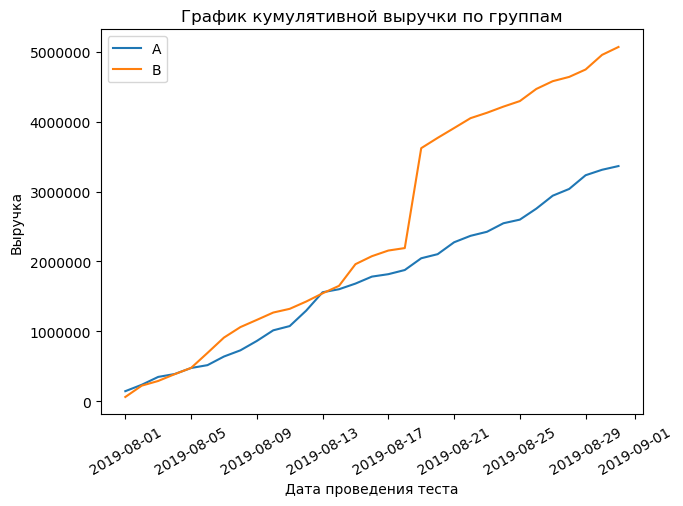

In [19]:
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'transaction_id']]
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'transaction_id']]

plt.figure(figsize=(7,5))
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')
plt.title('График кумулятивной выручки по группам')
plt.ylabel('Выручка')
plt.xlabel('Дата проведения теста')
plt.xticks(rotation=30)
plt.legend()
plt.show()

Выручка увеличивается в течение всего теста. Однако график выручки для группы А резко растет 18.08.19. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. 

#### График кумулятивного среднего чека по группам

Построю графики среднего чека по группам — разделю кумулятивную выручку на кумулятивное число заказов:

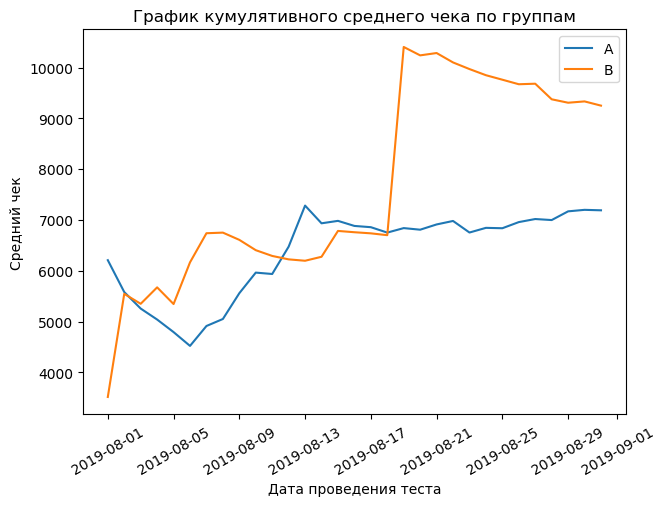

In [20]:
plt.figure(figsize=(7,5))
plt.plot(
            cumulative_revenue_a['date'], 
            cumulative_revenue_a['revenue']/cumulative_revenue_a['transaction_id'], 
            label='A'
        )

plt.plot(
            cumulative_revenue_b['date'], 
            cumulative_revenue_b['revenue']/cumulative_revenue_b['transaction_id'], 
            label='B'
        )

plt.title('График кумулятивного среднего чека по группам')
plt.ylabel('Средний чек')
plt.xlabel('Дата проведения теста')
plt.xticks(rotation=30)
plt.legend()
plt.show()

График для обеих групп крайне неравномерный в начале эксперимента, для группы А установился ближе к концу теста, для группы В в конце теста продолжает снижаться после пика 20.08.2019

#### График относительного изменения кумулятивного среднего чека группы В к группе А

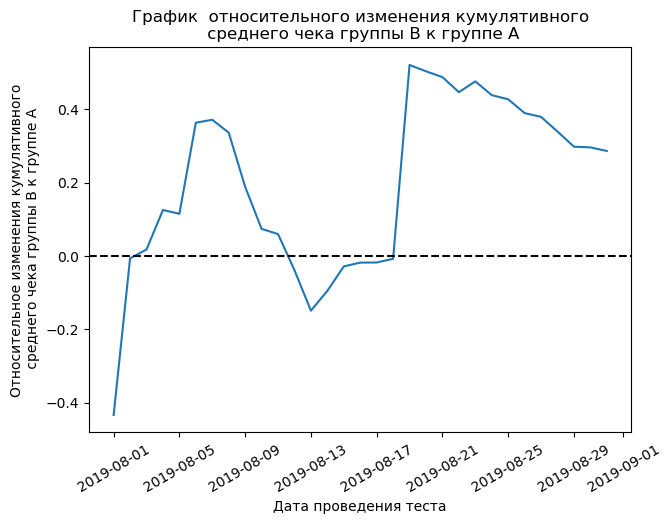

In [21]:
merged_cumulative_revenue = cumulative_revenue_a.merge(
                                                          cumulative_revenue_b, 
                                                          left_on='date', 
                                                          right_on='date', 
                                                          how='left', 
                                                          suffixes=['A', 'B']
                                                      )
plt.figure(figsize=(7,5))
plt.plot(
    merged_cumulative_revenue['date'], 
    (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['transaction_idB'])/ \
    (merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['transaction_idA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График  относительного изменения кумулятивного\n среднего чека группы В к группе А')
plt.xlabel('Дата проведения теста')
plt.ylabel('Относительное изменения кумулятивного\n среднего чека группы В к группе А')
plt.xticks(rotation=30)
plt.show()

В нескольких точках график различия между сегментами резко увеличивается или уменьшается. Это могут быть крупные заказы или выбросы.

#### График кумулятивного среднего количества заказов на посетителя по группам

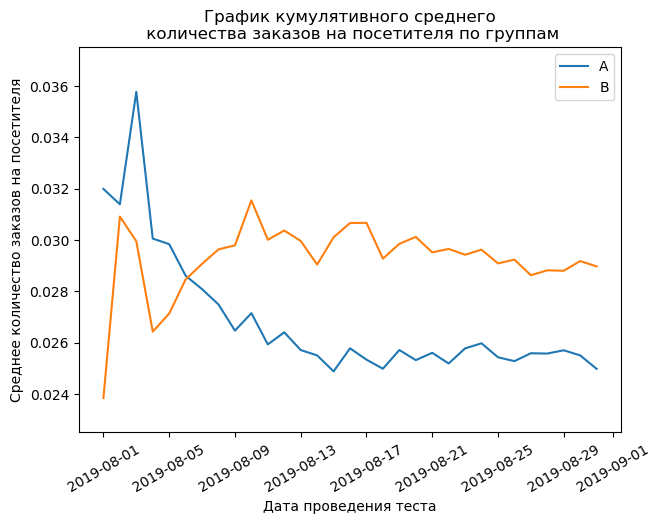

In [22]:
cumulative_data['avg_orders'] = cumulative_data['transaction_id']/cumulative_data['visitors']


# отделяем данные по группе А
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

plt.figure(figsize=(7,5))
plt.plot(cumulative_data_a['date'], cumulative_data_a['avg_orders'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['avg_orders'], label='B')
plt.title('График кумулятивного среднего\n количества заказов на посетителя по группам')
plt.ylabel('Cреднее количество заказов на посетителя')
plt.xlabel('Дата проведения теста')
plt.xticks(rotation=30)
# задаем масштаб осей
plt.ylim(0.0225, 0.0375)
plt.legend()
plt.show()

Группы колебались около одного значения, но затем среднее количество заказов на посетителя группы В вырвалось вперёд и зафиксировалось, а у группы А просело и также зафиксировалась.

#### График относительного изменения кумулятивного среднего количества заказов на посетителя группы В к группе А 

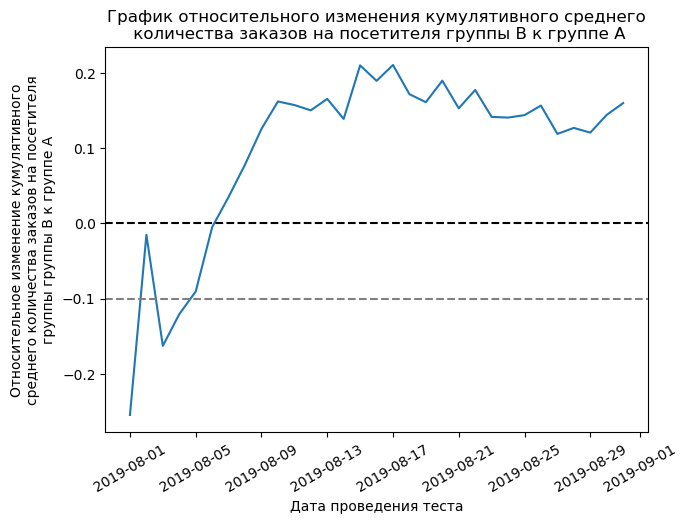

In [23]:
merged_cumulative_avg = cumulative_data_a[['date','avg_orders']].merge(
                                                                         cumulative_data_b[['date','avg_orders']], 
                                                                         left_on='date', 
                                                                         right_on='date', 
                                                                         how='left', 
                                                                         suffixes=['A', 'B']
                                                                      )
plt.figure(figsize=(7,5))
plt.plot(
           merged_cumulative_avg['date'], 
           merged_cumulative_avg['avg_ordersB']/merged_cumulative_avg['avg_ordersA']-1, 
        )

plt.title('График относительного изменения кумулятивного среднего\n количества заказов на посетителя группы В к группе А')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.xlabel('Дата проведения теста')
plt.ylabel('Относительное изменение кумулятивного\nсреднего количества заказов на посетителя\nгруппы группы В к группе А')
plt.xticks(rotation=30)
plt.show()

В начале теста группа B проигрывала группе A, затем вырвалась вперёд. В целом график колеблется к концу теста, и сейчас делать какие-либо выводы по тесту сложно.

#### График количества заказов по пользователям

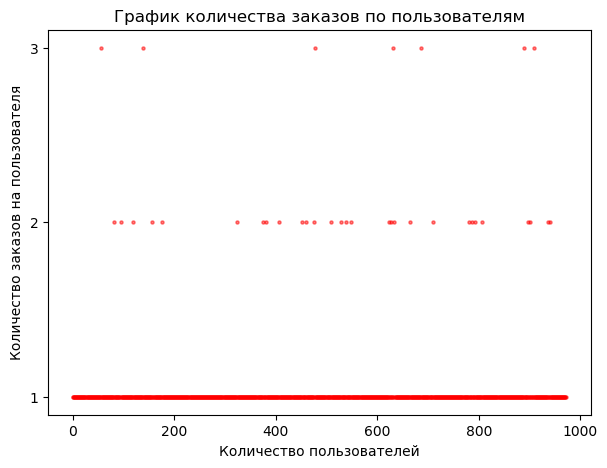

In [24]:
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users.columns =  ['visitor_id', 'orders']

x_values = pd.Series(range(0, len(orders_by_users)))
plt.figure(figsize=(7,5))
plt.scatter(x_values, orders_by_users['orders'], alpha=0.5, s=5, color='red', marker='o')
plt.yticks(orders_by_users.orders.unique())
plt.title('График количества заказов по пользователям')
plt.ylabel('Количество заказов на пользователя')
plt.xlabel('Количество пользователей')
plt.show()

Практически все пользователи делали 1 заказ, малая часть пользователей 2 заказа, и всего лишь несколько пользователей сделали 3 закаказа.

#### Расчет 95 и 99 перцентиля количества заказов на пользователя

In [25]:
print(np.percentile(orders_by_users['orders'], [95, 99]))

[1. 2.]


Не больше 1 % пользователей сделали 3 заказа. Оставлю 2 заказа на одного пользователя за верхнюю границу числа заказов, и отсею аномальных пользователей по ней.

#### График стоимостей заказов

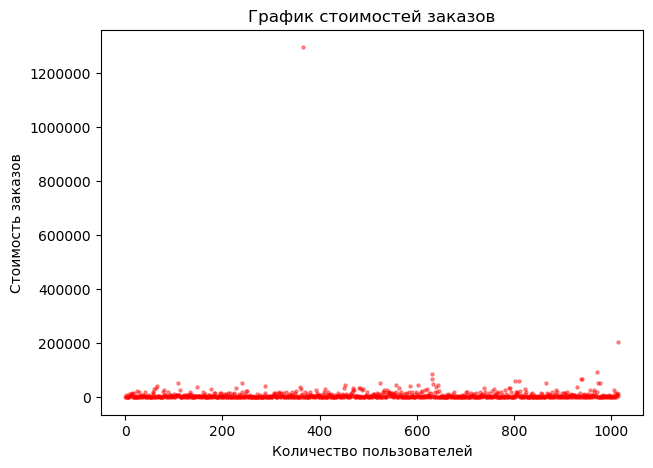

In [26]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(7,5))
plt.scatter(x_values, orders['revenue'], alpha=0.4, s=5, color='red', marker='o')
plt.title('График стоимостей заказов')
plt.ylabel('Стоимость заказов')
plt.xlabel('Количество пользователей')
plt.show()

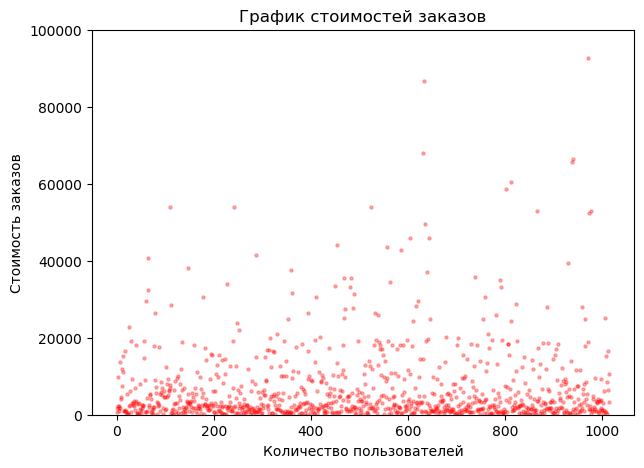

In [27]:
plt.figure(figsize=(7,5))
plt.scatter(x_values, orders['revenue'], alpha=0.3, s=5, color='red', marker='o')
plt.ylim(-0.1, 100000)
plt.title('График стоимостей заказов')
plt.ylabel('Стоимость заказов')
plt.xlabel('Количество пользователей')
plt.show()

Практически все заказы стоимостью до 40 000. Есть выбросы со стоимостью заказа более 1 200 000.

#### Расчет 95 и 99 перцентиля стоимости заказов

In [28]:
print(np.percentile(orders['revenue'], [95, 99]))

[26785. 53904.]


95 % пользователей тратят на заказ до 26 785. Не более 1 % заказов дороже 53 904. Поэтому верхней границей стоимости заказа будет сумма равная 53 904.

#### Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по "сырым" данным

На предыдущих шагах были оценены результаты A/B-теста визуально. Выяснила, что в данных есть выбросы, нашла границу для их определения.

Рассчитаю статистическую значимость различий в среднем числе заказов на пользователя между группами по «сырым» данным — без удаления аномальных пользователей.

**Сформулирую нулевую гипотезу:**

**H₀** = Различий в среднем количестве заказов на посетителя между группами нет

**Исходя из нулевой гипотезы сформулирую альтернативную:**

**H₁** = Различия в среднем количестве заказов посетителя между группами есть

Уровень статистической значимости **α** = 0.05
Проверка статистической значимости будет производиться с помощью критерия Манна-Уитни, так как этот тест учитывает выбросы в данных путем ранжирования значений.

In [29]:
total_visitors_a = visitors.query('group == "A"').visitors.sum()
total_visitors_b = visitors.query('group == "B"').visitors.sum()

orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['user_id', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['user_id', 'orders']

sample_a = pd.concat([orders_by_users_a['orders'],
                     pd.Series(0, index=np.arange(total_visitors_a - \
                     len(orders_by_users_a['orders'])), name='orders')],axis=0)

sample_b = pd.concat([orders_by_users_b['orders'],
                      pd.Series(0, index=np.arange(total_visitors_b - \
                      len(orders_by_users_b['orders'])), name='orders')],axis=0)

print('p-value: {0:.3f}'.format(stats.mannwhitneyu(sample_a, sample_b)[1]))
print('Относительный прирост среднего числа заказов на посетителя группы B: \
      {0:.3f}'.format(sample_b.mean() / sample_a.mean() - 1))

p-value: 0.006
Относительный прирост среднего числа заказов на посетителя группы B:       0.160


По «сырым» данным есть различия в среднем числе заказов на посетителя групп A и B.
P-value меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов на посетителя между группами нет, отвергаем. Относительный выйгрыш группы B равен 16 %.

#### Расчет статистической значимости различий в среднем чеке заказа между группами по "сырым" данным

Рассчитаю статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным — без удаления аномальных пользователей.

**Сформулирую нулевую гипотезу:**

**H₀** = Различий в среднем чеке заказа между группами нет

**Исходя из нулевой гипотезы сформулирую альтернативную:**

**H₁** = Различия в среднем чеке заказа между группами есть

Уровень статистической значимости **α** = 0.05 
Проверка статистической значимости будет производиться с помощью критерия Манна-Уитни, так как этот тест учитывает выбросы в данных путем ранжирования значений.

In [30]:
print('p-value: {0:.3f}'.format(stats.mannwhitneyu(
                                            orders[orders['group']=='A']['revenue'], 
                                            orders[orders['group']=='B']['revenue'])[1]))

print('Относительный прирост среднего чека заказа в группе B: {0:.3f}'.format(
                         orders[orders['group']=='B']['revenue'].mean()/ \
                         orders[orders['group']=='A']['revenue'].mean()-1))

p-value: 0.415
Относительный прирост среднего чека заказа в группе B: 0.287


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Средний чек группы B больше среднего чека группы A на 28.7 %.

#### Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по "очищенным" данным

Приму за аномальных пользователей тех, кто совершил больше 2 заказов или совершил заказ дороже 53 904 рублей. Сделаю срезы пользователей с числом заказов больше 2 — `anomaly_orders` и пользователей, совершивших заказы дороже 53 904 — `anomaly_cost`. Объединю их в таблице `anomaly_users`.

Узнаю, сколько всего аномальных пользователей атрибутом `shape`.

In [31]:
orders_limit = np.percentile(orders_by_users['orders'], 99)
cost_limit = np.percentile(orders['revenue'], 99)

anomaly_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > orders_limit]['user_id'],
        orders_by_users_b[orders_by_users_b['orders'] > orders_limit]['user_id'],
    ],
    axis=0,
)
anomaly_cost = orders[orders['revenue'] > cost_limit]['visitor_id']

anomaly_users = (
    pd.concat([anomaly_orders, anomaly_cost], axis=0)
    .drop_duplicates()
    .sort_values()
)

print(anomaly_users.shape[0])

16


Всего 16 аномальных пользователей. Узнаю, как их действия повлияли на результаты теста. Посчитаю статистическую значимость различий в среднем количестве заказов на посетителя между группами теста по очищенным данным. Сначала подготовлю выборки количества заказов по пользователям по группам теста.

In [32]:
print(f'Относительный процент потерь в пользователях: \
      {round(anomaly_users.shape[0] / len(orders.visitor_id.unique() * 100), 2)} %')

Относительный процент потерь в пользователях:       0.02 %


По перцентилям убрала 1 % аномальных пользователей, относительный процент потерь в пользователях равен 0.02 %. Таких пользователей мало, но они могут исказить результаты анализа, поэтому отфильтрую этих пользователей.

**Сформулирую нулевую гипотезу:**

**H₀** = Различий в среднем количестве заказов на посетителя между группами по очищенным данным нет

**Исходя из нулевой гипотезы сформулирую альтернативную:**

**H₁** = Различия в среднем количестве заказов на посетителя между группами по очищенным данным есть

Уровень статистической значимости **α** = 0.05
Проверка статистической значимости будет производиться с помощью критерия Манна-Уитни.

In [33]:
sample_a_filter = pd.concat(
    [orders_by_users_a[np.logical_not(orders_by_users_a['user_id'].isin(anomaly_users))]['orders'],
    pd.Series(0, index=np.arange(total_visitors_a - len(orders_by_users_a['orders'])), name='orders')],
    axis=0)

sample_b_filter = pd.concat(
    [orders_by_users_b[np.logical_not(orders_by_users_b['user_id'].isin(anomaly_users))]['orders'],
    pd.Series(0, index=np.arange(total_visitors_b - len(orders_by_users_b['orders'])), name='orders')],
    axis=0)

print('p-value: {0:.3f}'.format(stats.mannwhitneyu(sample_a_filter, sample_b_filter)[1]))
print('Относительный прирост среднего числа заказов на посетителя группы B: {0:.3f}' \
      .format(sample_b_filter.mean()/sample_a_filter.mean()-1))

p-value: 0.004
Относительный прирост среднего числа заказов на посетителя группы B: 0.189


Результаты по среднему количеству заказов практически не изменились.

#### Расчет статистической значимости различий в среднем чеке заказа между группами по "очищенным" данным

Рассчитаю статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

**Сформулирую нулевую гипотезу:**

**H₀** = Различий в среднем чеке заказа между группами по очищенным данным нет

**Исходя из нулевой гипотезы сформулирую альтернативную:**

**H₁** = Различия в среднем чеке заказа между группами по очищенным данным есть

Уровень статистической значимости **α** = 0.05 
Проверка статистической значимости будет производиться с помощью критерия Манна-Уитни.

In [34]:
print(
    'p-value: {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(anomaly_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(anomaly_users)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Относительный прирост среднего чека заказа в группе B: {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(anomaly_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(anomaly_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value: 0.394
Относительный прирост среднего чека заказа в группе B: -0.032


P-value немного уменьшился, но все так же больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. 
Однако, средние чеки выровнялись, разница между группа А и В по среднему чеку сократилась до 3%.

### Вывод

В ходе работы были приоритезированы гипотезы и сделан анализ А/В теста. На основе анализа данных, были сделаны следущие выводы:

1. **Необходимо обратить внимание на следующие гипотезы:**

- Если не нужно учитывать охват пользователей интернет-магазина:


    - "Запустить акцию, дающую скидку на товар в день рождения",
    - "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",

- Если необходимо учитывать охват пользователей интернет-магазина:


    - "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",
    - "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",

2. **Результаты А/В теста**

- Необходимо учитывать момент, связанный с попаданием пользователей в 2 группы одновременно
- По «сырым» и «очищенным» данным есть различия в среднем числе заказов на посетителя групп A и B. Группа В выигрывает на 18.9% по «очищенным» данным и на 16 % по «сырым»
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий. По «очищенным» данным различия между группами практически отсутствуют, по «сырым» средний чек группы В на 28.7% больше.
- График различия среднего количества заказов на посетителя между группами сообщает, что результаты группы B колеблются, но держатся на высоком уровне
- График различия среднего чека говорит о том, что результаты группы B ухудшаются начиная с 20.08.19


**Рекомендую остановить тест, зафиксировав победу группы B; при имеющихся данных сегмент B лучше сегмента A**